<a href="https://colab.research.google.com/github/maverick98/CDS/blob/main/M6_SNB_MiniProject_2_EDA_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Exploratory Data Analysis Timeseries

**DISCLAIMER:** THIS NOTEBOOK IS PROVIDED ONLY AS A REFERENCE SOLUTION NOTEBOOK FOR THE MINI-PROJECT. THERE MAY BE OTHER POSSIBLE APPROACHES/METHODS TO ACHIEVE THE SAME RESULTS.

## Problem Statement

Perform Exploratory Data Analysis (EDA) of the time series data using visualizations and statistical methods.

## Learning Objectives

At the end of the mini-project, you will be able to :

* perform Exploratory data analysis (EDA) of the time series
* perform Time series behaviour analysis in qualitative and quantitative terms
* summarize the findings based on the EDA

## Dataset

The dataset is a French retail company quarterly sales data that has been made available from  Prof. Rob Hyndman's ["Forecasting Methods & Applications"](https://robjhyndman.com/forecasting/) book. There are 24 entries, from 2012-03-31 to 2017-12-31 (Quarterly sales values).

## Introduction

Exploratory data analysis of time series data starts with data visualization. 

- Are there consistent patterns? 
- Is there a significant trend? 
- Is seasonality important? 
- Is there evidence of the presence of business cycles? 
- Are there any outliers in the data that need to be explained by those with expert knowledge? 
- How strong are the relationships among the variables available for analysis?

Various tools have been developed to help with these analyses. 

In [1]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/ts_frenchretail.csv

## Grading = 10 Points

### Importing libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')
%matplotlib inline
import scipy
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

<ipython-input-2-1e22105a2b88>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


### Importing Data

In [3]:
# Read dataset with 'Date' as index
data = pd.read_csv('ts_frenchretail.csv', parse_dates=True, index_col="Date")
data.head()       

,Sales
Date,
2012-03-31,362000
2012-06-30,385000
2012-09-30,432000
2012-12-31,341000
2013-03-31,382000


## Exploratory Data Analysis

### **Preprocessing** (1 point)

#### Divide the sales by 1000

Sales numbers are in thousands, so divide by 1000 to make it easier to work with numbers

In [4]:
data['Sales'] = data['Sales']/1000
data.head()

,Sales
Date,
2012-03-31,362.0
2012-06-30,385.0
2012-09-30,432.0
2012-12-31,341.0
2013-03-31,382.0


#### Check for missing values     

In [5]:
data.isna().sum()

Sales    0
dtype: int64

### **Visualization**

#### Visualize the time series (2012 to 2017) (1 point)

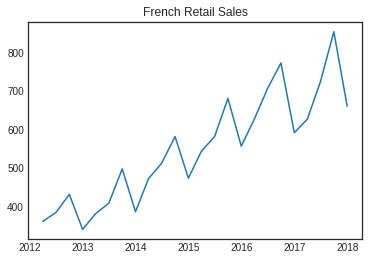

In [6]:
plt.plot(data.Sales)
plt.title("French Retail Sales")
plt.show()

There is a clear and increasing trend. There is also a seasonal pattern that increases in size as the level of the series increases. Any forecasts of this series would need to capture the seasonal pattern and the fact that the trend is changing slowly.

#### Visualize the data year-wise and quarter-wise (2 points)

- Box plot to see distribution of sales in each year
- Create year-wise subplots to visualize the quarterly Sales per year
- Compute Percentage growth each year

Make a report of your observations.

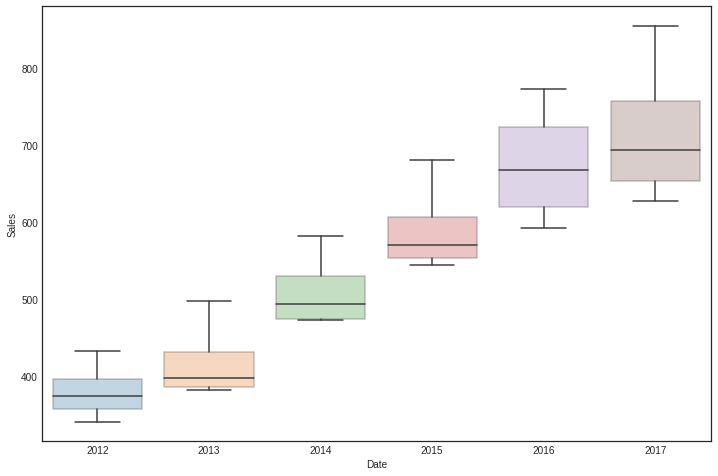

In [8]:
# Box plot to see distribution of sales in each year
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(data= data, x= data.index.year, y = 'Sales',  ax = ax, boxprops=dict(alpha=.3));
#sns.swarmplot(data= data, x= data.index.year, y = 'Sales');
plt.show()

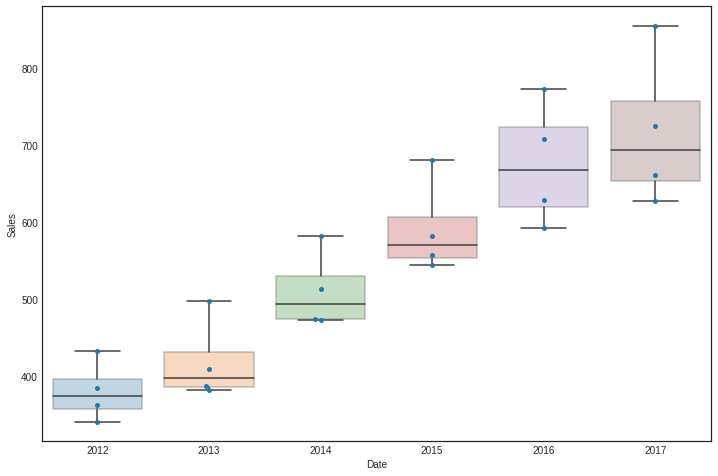

In [9]:
# Box plot to see distribution of sales in each year
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(data= data, x= data.index.year, y = 'Sales',  ax = ax, boxprops=dict(alpha=.3));
sns.swarmplot(data= data, x= data.index.year, y = 'Sales');
plt.show()

In [10]:
# Different years
yrs = data.index.year.unique()
yrs

Int64Index([2012, 2013, 2014, 2015, 2016, 2017], dtype='int64', name='Date')

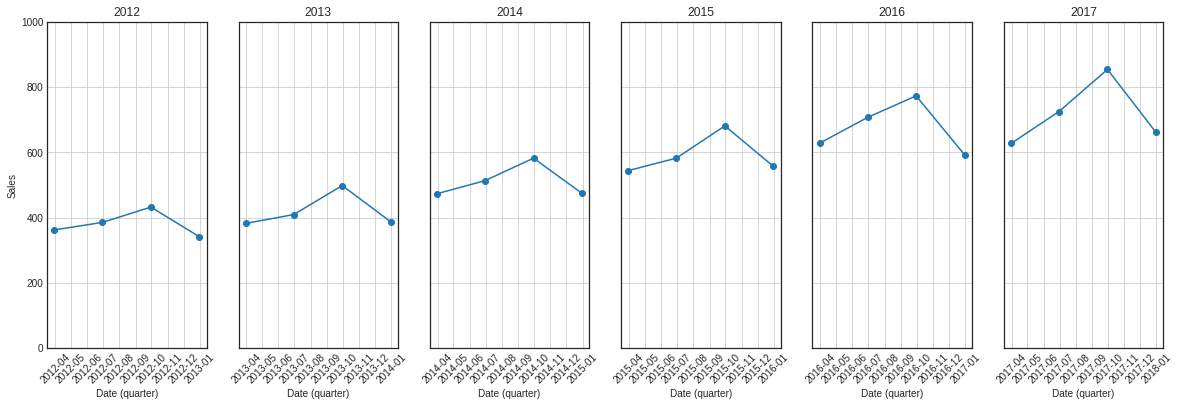

In [11]:
# Create year-wise subplots to visualize the quarterly Sales per year
fig, ax = plt.subplots(1, len(yrs), sharey= True, figsize= (20, 6))

for i in range(len(yrs)):
    ax[i].plot(data.index[data.index.year == yrs[i]], data.Sales[data.index.year == yrs[i]], marker='o');
    ax[i].grid() 
    ax[i].set_title(yrs[i])
    ax[i].set_xlabel('Date (quarter)')
    ax[i].set_ylim([0, 1000]) 
    ax[i].tick_params('x', labelrotation=45) 
ax[0].set_ylabel('Sales')

plt.show()

In [12]:
# Percentage growth each year
growth = data.groupby(data.index.year)["Sales"].sum().pct_change()
growth*100

Date
2012          NaN
2013    10.263158
2014    21.837709
2015    15.768854
2016    14.213198
2017     6.185185
Name: Sales, dtype: float64

From the above results, we can see that
- Sales has gone up each year from 2012-2017 => Positive Trend present. 
- Typically, Sales goes up from Q1 to Q3, peaks in Q3, drops in Q4. Definitely a seasonal pattern. => Model should capture seasonality and trend.
- Just comparing Q4 peaks, sales has gone up from \$432K to \$582K => Trend exists, Model should capture trend. No cyclic behaviour
- Overall data looks clean, no observations outside of IQR => Clean data, no outliers
- No structural breaks, intermittent pattern
- Notice that the length of the bar in box plot increases from 2012-2017. => Mean & variance increasing, we will need to stabilize the variance by taking log

#### Visualize the distribution of the Sales (0.5 point)

While normally distributed data is not a requirement for forecasting and doesn't necessarily improve point forecast accuracy, it can help stablize the variance and narrow the prediction interval.

Report your observations.

Hint: `sns.distplot()`

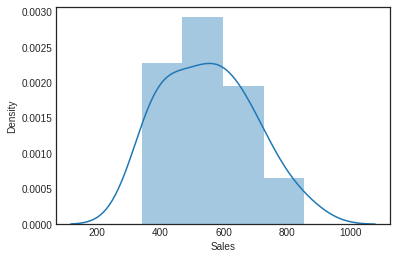

In [13]:
sns.distplot(data.Sales)
plt.show()

#### Visualize Quarterly trends (1 point)

Create quarterly subplots to visualize the data in each quarter across all years

Hint: statsmodels' `quarter_plot()` method

In [14]:
# Different months
months = data.index.month.unique()
months

Int64Index([3, 6, 9, 12], dtype='int64', name='Date')

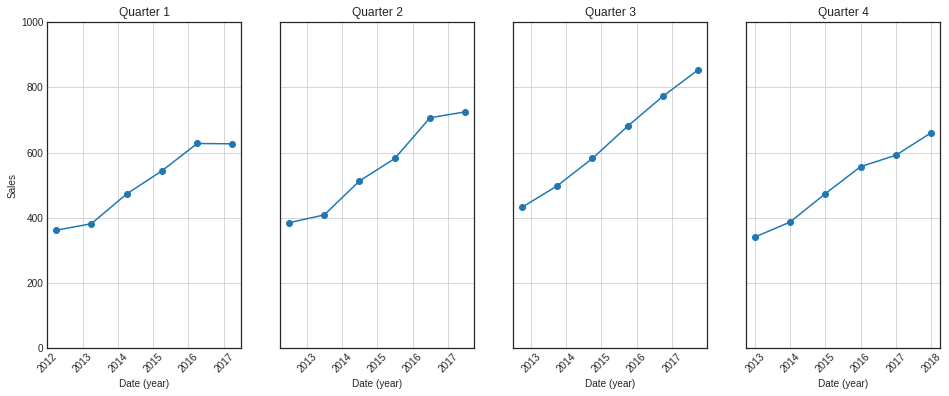

In [18]:
fig, ax = plt.subplots(1, len(months), sharey= True, figsize= (16, 6))

for i in range(len(months)):
    ax[i].plot(data.index[data.index.month == months[i]], data.Sales[data.index.month == months[i]], marker='o');
    ax[i].grid() 
    ax[i].set_title('Quarter '+str(i+1))
    ax[i].set_xlabel('Date (year)')
    ax[i].set_ylim([0, 1000]) 
    ax[i].tick_params('x', labelrotation=45) 
ax[0].set_ylabel('Sales')

plt.show()

>Also, statsmodels has a `quarter_plot()` method that can be used to create similar chart easily. 

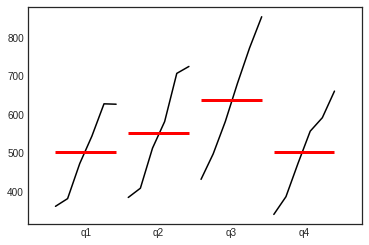

In [19]:
quarter_plot(data.Sales);

The above Quarter plot confirm peak in Q3, drop in Q4. For each of the years the upward trend observed in all quarters.

#### Visualize the distribution of Sales in each year within a single plot (1 point)

- Do the distribution peaks shift to the right from 2012 to 2017? What does this indicate?
- Is there a change in the width of the distributions from 2012 to 2017? What does it signify?

Hint: `sns.distplot(hist=False)`

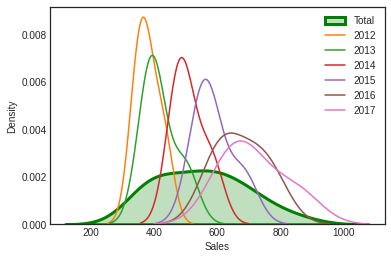

In [20]:
# Distribution plot of each year
sns.distplot(data.Sales,         label='Total', hist=False, kde_kws={"color": "g", "lw": 3, "label": "Total", "shade":True})
sns.distplot(data.Sales['2012'], label='2012', hist=False)
sns.distplot(data.Sales['2013'], label='2013', hist=False)
sns.distplot(data.Sales['2014'], label='2014', hist=False)
sns.distplot(data.Sales['2015'], label='2015', hist=False)
sns.distplot(data.Sales['2016'], label='2016', hist=False)
sns.distplot(data.Sales['2017'], label='2017', hist=False)
plt.legend()
plt.show()

Kenel Density plot shows data looks normally distributed, bi-modal distribution in quarters is because of small sample size. Peaks shift right from 2012 to 2017 indicating increase in average.
Distribution becomes fatter as the years progress, indicating higher spread/variation.

#### Visualize the quarterly sales for each year using a stacked bar plot (1 point)

In [21]:
df1 = data.copy()
df1['year'] = df1.index.year
df1['quarter'] = df1.index.quarter
df1.head()

,Sales,year,quarter
Date,,,
2012-03-31,362.0,2012,1
2012-06-30,385.0,2012,2
2012-09-30,432.0,2012,3
2012-12-31,341.0,2012,4
2013-03-31,382.0,2013,1


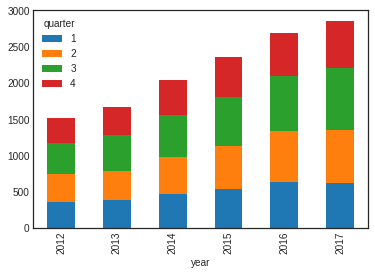

In [22]:
df1.pivot('year', 'quarter', 'Sales').plot.bar(stacked=True)
plt.show()

#### Check if the time series data is stationary (1 point)

Hint:

For the series to be stationary, it must have:
 - constant mean
 - constant variance
 - constant covariance (uncorrelated)

Visualize if the mean is constant

Hint: [Rolling mean](https://pandas.pydata.org/docs/reference/api/pandas.core.window.rolling.Rolling.mean.html)

Mean is: 548.7083333333334


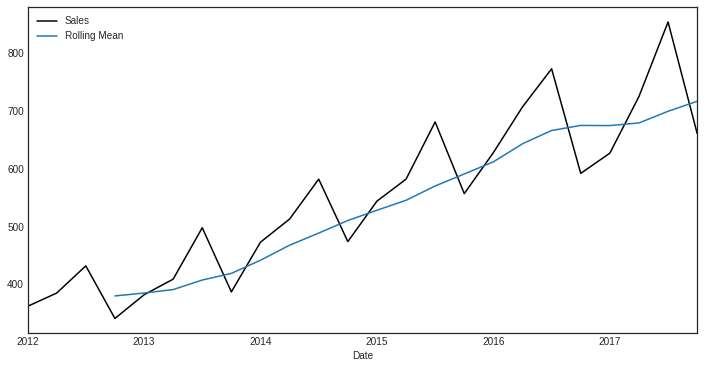

In [23]:
# Visualize Rolling mean
data.Sales.plot(figsize=(12,6), legend=True, label="Sales", cmap='gray')
data.Sales.rolling(4, center=False).mean().plot(legend=True, label="Rolling Mean");
print("Mean is:", data.Sales.mean())

Notice that each year, the difference between the mean and the max in Q3 increases. This can potentially mean multiplicative seasonality.

Visualize if the variance is constant

Hint: [Rolling standard deviation](https://pandas.pydata.org/docs/reference/api/pandas.core.window.rolling.Rolling.std.html)

S.D is: 140.40


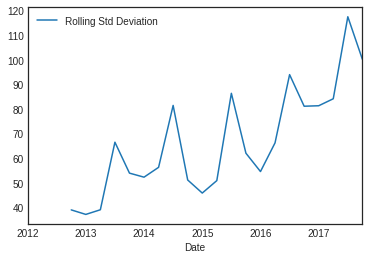

In [24]:
# Rolling standard deviation
data.Sales.rolling(4).std().plot(legend=True, label="Rolling Std Deviation");
print("S.D is: {:.2f}".format(data.Sales.std()))

Based on the observations report whether the series is stationary or not.

Both mean and standard deviation are increasing, thus the series is **not stationary**. 

#### Visualize the patterns in time series - trend, seasonality, residuals (1 point)

Hint: See Module 6 - AST3 EDA > Patterns in a time series

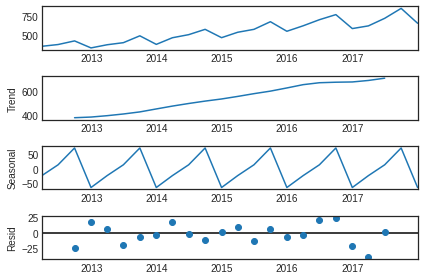

In [25]:
# Applying seasonal decompose
result = seasonal_decompose(data)

# Plotting trend, seasonality
result.plot()
plt.show()

Report if there are any observable patterns in terms of trend, seasonality , or cyclic behavior.

In the above plot,
- Trend is linear and projecting upward
- Seasonal pattern is consistent
- We do not want to see any recognizable patterns in the residuals, e.g. waves, upward/downward slope, funnel pattern etc. 


### **Detrending**

####  Detrend the time series (0.5 point)

Detrending a time series is to remove the trend component from a time series.

Hint: 
- Subtract the line of best fit `scipy.signal.detrend()`

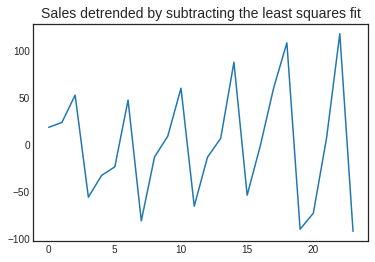

In [26]:
# Using scipy: Subtract the line of best fit
detrended = signal.detrend(data.Sales.values)

plt.plot(detrended)
plt.title('Sales detrended by subtracting the least squares fit', fontsize=14)
plt.show()

### **Lag Plots** (Optional)

#### Visualize the Lag plots

A Lag plot is a scatter plot of a time series against a lag of itself. It is normally used to check for autocorrelation. If there is any pattern existing in the series, the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.

For reference, see Module 6 - AST3 > Lag Plots 

Hint: `pandas.plotting.lag_plot()`

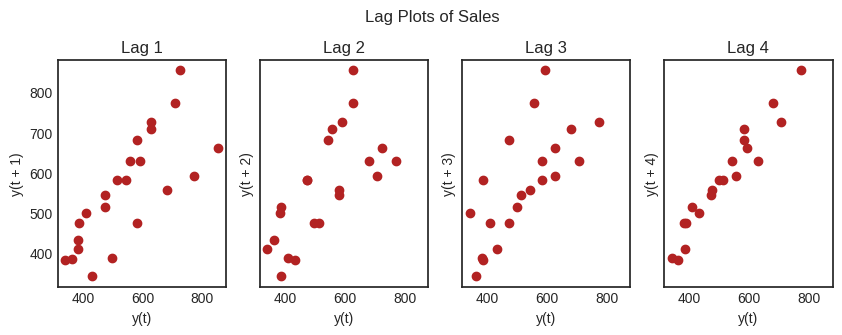

In [27]:
# Visualize lag plots
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(data.Sales, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Sales', y=1.05)    
plt.show()

### Report Analysis

- Give the summary about this time series

The summary of this time series is as follows:
- There are no null values, outliers or duplicate values in the series. Series is continuous, non-intermittent. No structural breaks. We don't have to do any cleaning.
- Series has a trend. Sales have increased every year. It looks more than linear but less than exponential. 
- Series has seasonality with seasonal periods = 4. Peak in Q3, drops in Q4, ramps up from Q1 to Q3. No other dominant periods. No cyclic behaviour.
- Mean, variance, covariance are not constant. Series is not stationary, not white noise and not random-walk.
- Variance increasing with time. Highs also look to be increasing relative to mean (rolling avg).
- Series is normally distributed